local에서 실험 할 CNN 목록

Gemini 사용하여 pytorch로 구현

Alexnet, Vgg16, googlenet, resnet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_file_name = '/content/drive/MyDrive/기학기/real_fake_dataset.zip'
extraction_dir = '/content/dataset'

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
import time
import copy


# import h5py
# import cv2

In [4]:
# 설정값

IMG_SIZE = 224
EPOCHS = 30
BATCH_SIZE = 64
NUM_SAMPLES = 10000
LEARNING_RATE = 1e-4
PATIENCE = 5

In [5]:
# 이미지 전처리 클래스
# 비율 유지하며 resize 후 패딩 추가(0으로)
class ResizeWithPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size

        scale = self.target_size / max(w, h)

        new_w = int(w * scale)
        new_h = int(h * scale)

        # 비율 유지하며 리사이즈
        resized_img = img.resize((new_w, new_h), Image.LANCZOS)

        # 검은색 캔버스 생성
        canvas = Image.new("RGB", (self.target_size, self.target_size), (0, 0, 0))

        # 캔버스 중앙에 리사이즈된 이미지 배치
        pad_x = (self.target_size - new_w) // 2
        pad_y = (self.target_size - new_h) // 2

        canvas.paste(resized_img, (pad_x, pad_y))

        return canvas

In [7]:
# def preprocess(path, FT = None):  # 이미지 전처리
#   img = Image.open(path)

#   if FT != None:
#     img = pre_transform(img)  # 전전처리 적용
#     img = preprocess_FT(img, FT)
#     processed_img_tensor = after_FT_transform(img)  # 후전처리 적용

#   elif FT == None:
#     processed_img_tensor = transform(img)

#   return processed_img_tensor


FT_type = ['phase_only', 'amplitude_only', 'shuffle_global_amplitude', 'shuffle_patch_amplitude', 'average_amplitude', 'shuffle_patch_phase']

# 푸리에 변환 함수
def preprocess_FT(img: Image.Image, Type=None):
    Type = FT_type[Type]

    # 1) Grayscale 변환
    img_np = np.array(img.convert("L")).astype(np.float32)

    # 2) FFT 수행 + 중심 이동
    F = np.fft.fft2(img_np)
    Fshift = np.fft.fftshift(F)

    amp = np.abs(Fshift)
    phase = np.angle(Fshift)

    #  CASE 1: Phase-only
    if Type == 'phase_only':
        # amplitude = 1, phase만 사용 → 다시 ifft로 복원
        F_new = np.exp(1j * phase)
        img_out = np.fft.ifft2(np.fft.ifftshift(F_new))
        img_out = np.real(img_out)

    #  CASE 2: Amplitude-only
    elif Type == 'amplitude_only':
        # 핵심: log amplitude 사용
        img_out = np.log(amp + 1e-8)

    else:
        img_out = img_np


    #  마지막 정규화 (0~255)
    img_out = img_out - img_out.min()
    img_out = img_out / (img_out.max() + 1e-8)
    img_out = (img_out * 255).astype(np.uint8)

    # Gray → 3채널로 변환
    img_out = np.stack([img_out]*3, axis=-1)

    return Image.fromarray(img_out)

In [8]:
# 데이터셋
# 디스크의 이미지 경로 리스트를 받아,
# 배치 생성 시점에만 이미지를 읽어옴
class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform=None, apply_ft=False, ft_type=0):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.apply_ft = apply_ft
        self.ft_type = ft_type

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # 디스크에서 이미지 경로로 이미지 로드 (PIL)
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')

        # FT domain 변환 적용
        if self.apply_ft:
          image = preprocess_FT(image, self.ft_type)

        # 전처리 적용
        if self.transform:
            image = self.transform(image)

        # 라벨을 float 텐서로 변환 (BCEWithLogitsLoss용)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return image, label.unsqueeze(0) # (1,) 형태로 반환


In [9]:
class AlexNetLike(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNetLike, self).__init__()
        self.features = nn.Sequential(
            # Conv 1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), # 224 -> 55
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 55 -> 27

            # Conv 2
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # 27 -> 27
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 27 -> 13

            # Conv 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 13 -> 13
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            # Conv 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # 13 -> 13
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            # Conv 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 13 -> 13
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13 -> 6
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes) # num_classes=1
        )
    def forward(self, x):
        x = self.features(x); x = self.avgpool(x)
        x = torch.flatten(x, 1); x = self.classifier(x)
        return x

In [10]:
def get_model(model_name, device):

    model = None
    num_classes = 1 # 이진 분류 (Real/Fake)

    print(f"Loading {model_name} architecture (FROM SCRATCH)...")

    if model_name.lower() == 'alexnet':
        # 직접 짠 AlexNet (Conv 5, FC 3)
        model = AlexNetLike(num_classes=num_classes)

    elif model_name.lower() == 'vgg16':
        # VGG16
        model = models.vgg16(weights=None, num_classes=num_classes)

    elif model_name.lower() == 'googlenet':
        # GoogLeNet
        model = models.googlenet(weights=None, num_classes=num_classes, aux_logits=False)

    elif model_name.lower() == 'resnet50':
        # ResNet50
        model = models.resnet50(weights=None, num_classes=num_classes)

    else:
        raise ValueError(f"Unknown model name: {model_name}. Choose from 'alexnet, 'vgg16', 'googlenet', 'resnet50'")

    return model.to(device)

In [11]:
# 학습
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience):
    print("=== 학습 시작 ===")

    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        start_time = time.time()

        # --- 훈련 ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # tqdm으로 진행 상황 표시
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # 정확도 계산
            preds = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

            train_pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # --- 검증 ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)

                preds = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val

        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - {elapsed_time:.0f}s - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # --- Early Stopping 및 Best Model 저장 ---
        if epoch_val_loss < best_val_loss:
            print(f"  Validation loss decreased ({best_val_loss:.4f} --> {epoch_val_loss:.4f}). Saving model...")
            best_val_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(best_model_weights, MODEL_SAVE_PATH)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("=== 학습 완료 ===")
    model.load_state_dict(best_model_weights)
    return model

In [12]:
# 평가
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    print("\n=== 테스트셋 평가 시작 ===")
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc="[Test]", leave=False)
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            total_test += labels.size(0)
            correct_test += (preds == labels).sum().item()

    test_loss = running_test_loss / len(test_loader.dataset)
    test_acc = correct_test / total_test

    print(f"===== 최종 테스트 결과 =====")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc * 100:.2f}%")

In [13]:
# 메인 실행
start_time = time.time()

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === 데이터 경로 수정 ===
base_dir = "/content/dataset/real_fake_dataset"
face_real_dir = os.path.join(base_dir, "face_real")
face_fake_dir = os.path.join(base_dir, "face_fake")

MODEL_SAVE_PATH = "/content/drive/MyDrive/deepfake_baseline_model.pth"

print("이미지 경로 수집 중...")
real_paths = glob.glob(os.path.join(face_real_dir, "*"))
fake_paths = glob.glob(os.path.join(face_fake_dir, "*"))

all_paths = real_paths + fake_paths
all_labels = [0] * len(real_paths) + [1] * len(fake_paths)

print(f"총 {len(all_labels)}개 이미지 경로 발견.")

# 샘플 개수 제한
NUM_SAMPLES = min(NUM_SAMPLES, len(all_paths))

print(f"{NUM_SAMPLES}개 샘플을 샘플링...")
_, target_paths, _, target_labels = train_test_split(
    all_paths, all_labels,
    test_size=NUM_SAMPLES,
    random_state=42,
    stratify=all_labels
)

print(f"샘플링 완료: {len(target_labels)}개 이미지 선택.")


Using device: cuda
이미지 경로 수집 중...
총 68479개 이미지 경로 발견.
10000개 샘플을 샘플링...
샘플링 완료: 10000개 이미지 선택.


In [14]:
# 7:2:1 분할 (Keras와 동일)
print("데이터를 7:2:1 비율로 분할합니다...")
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    target_paths, target_labels, test_size=0.3, random_state=42, stratify=target_labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=(1/3), random_state=42, stratify=temp_labels
)
print(f"분할 완료: Train {len(train_paths)}개, Validation {len(val_paths)}개, Test {len(test_paths)}개")

# 전처리 및 데이터 로더 정의
train_transform = transforms.Compose([
    ResizeWithPad(IMG_SIZE),
    # transforms.RandomHorizontalFlip(), # 데이터 증강
    transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
    transforms.RandomRotation(10),    #+- 10도 회전
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # -1 ~ 1 정규화
])

val_test_transform = transforms.Compose([
    ResizeWithPad(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = DeepfakeDataset(train_paths, train_labels, transform=train_transform, apply_ft=True, ft_type=1)
val_dataset = DeepfakeDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = DeepfakeDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("데이터 로더 생성 완료.")


데이터를 7:2:1 비율로 분할합니다...
분할 완료: Train 7000개, Validation 2000개, Test 1000개
데이터 로더 생성 완료.


In [16]:
# 데이터 전처리 및 RAM에 로드
print("데이터 전처리를 시작합니다 (모든 데이터를 RAM에 로드)...")
start_time = time.time()
def load_images_to_ram(paths, transform):
    tensor_list = []
    for path in tqdm(paths, desc="Loading images to RAM"):
        img = Image.open(path).convert('RGB')
        tensor_list.append(transform(img))
    return torch.stack(tensor_list)

# 이미지 필요할 때만 읽어서 GPU에 올림
train_dataset = DeepfakeDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DeepfakeDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = DeepfakeDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("데이터 로더 생성 완료.")

# 8. 모델, 손실함수, 옵티마이저 정의
model = get_model('googlenet', device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 9. 학습 및 평가
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS, PATIENCE)
evaluate_model(model, test_loader, criterion, device)

print(f"총 실행 시간: {(time.time() - start_time) / 60:.2f} 분")

데이터 전처리를 시작합니다 (모든 데이터를 RAM에 로드)...
데이터 로더 생성 완료.
Loading googlenet architecture (FROM SCRATCH)...
=== 학습 시작 ===


Epoch 1/30 - 59s - Train Loss: 0.6802, Train Acc: 0.5689 - Val Loss: 0.6731, Val Acc: 0.5830
  Validation loss decreased (inf --> 0.6731). Saving model...


Epoch 2/30 - 57s - Train Loss: 0.6616, Train Acc: 0.6044 - Val Loss: 0.6945, Val Acc: 0.5540
  Validation loss did not improve. Patience: 1/5


Epoch 3/30 - 56s - Train Loss: 0.6470, Train Acc: 0.6207 - Val Loss: 0.6800, Val Acc: 0.5755
  Validation loss did not improve. Patience: 2/5


Epoch 4/30 - 56s - Train Loss: 0.6311, Train Acc: 0.6351 - Val Loss: 0.5997, Val Acc: 0.6630
  Validation loss decreased (0.6731 --> 0.5997). Saving model...


Epoch 5/30 - 56s - Train Loss: 0.6171, Train Acc: 0.6454 - Val Loss: 0.8131, Val Acc: 0.5570
  Validation loss did not improve. Patience: 1/5


Epoch 6/30 - 55s - Train Loss: 0.5855, Train Acc: 0.6766 - Val Loss: 1.3380, Val Acc: 0.5290
  Validation loss did not improve. Patience: 2/5


Epoch 7/30 - 55s - Train Loss: 0.5681, Train Acc: 0.6857 - Val Loss: 0.5657, Val Acc: 0.7110
  Validation loss decreased (0.5997 --> 0.5657). Saving model...


Epoch 8/30 - 56s - Train Loss: 0.5471, Train Acc: 0.7053 - Val Loss: 0.6201, Val Acc: 0.6550
  Validation loss did not improve. Patience: 1/5


Epoch 9/30 - 55s - Train Loss: 0.5244, Train Acc: 0.7207 - Val Loss: 0.6174, Val Acc: 0.7035
  Validation loss did not improve. Patience: 2/5


Epoch 10/30 - 55s - Train Loss: 0.5047, Train Acc: 0.7327 - Val Loss: 0.6308, Val Acc: 0.6615
  Validation loss did not improve. Patience: 3/5


Epoch 11/30 - 55s - Train Loss: 0.5020, Train Acc: 0.7499 - Val Loss: 0.4887, Val Acc: 0.7530
  Validation loss decreased (0.5657 --> 0.4887). Saving model...


Epoch 12/30 - 57s - Train Loss: 0.4786, Train Acc: 0.7493 - Val Loss: 0.7030, Val Acc: 0.6510
  Validation loss did not improve. Patience: 1/5


Epoch 13/30 - 56s - Train Loss: 0.4582, Train Acc: 0.7663 - Val Loss: 0.4891, Val Acc: 0.7675
  Validation loss did not improve. Patience: 2/5


Epoch 14/30 - 57s - Train Loss: 0.4569, Train Acc: 0.7723 - Val Loss: 0.5070, Val Acc: 0.7585
  Validation loss did not improve. Patience: 3/5


Epoch 15/30 - 56s - Train Loss: 0.4471, Train Acc: 0.7783 - Val Loss: 0.5173, Val Acc: 0.7365
  Validation loss did not improve. Patience: 4/5


Epoch 16/30 - 57s - Train Loss: 0.4310, Train Acc: 0.7897 - Val Loss: 0.7326, Val Acc: 0.6420
  Validation loss did not improve. Patience: 5/5
Early stopping triggered after 16 epochs.
=== 학습 완료 ===

=== 테스트셋 평가 시작 ===


===== 최종 테스트 결과 =====
  Test Loss: 0.4974
  Test Accuracy: 74.70%
총 실행 시간: 15.06 분


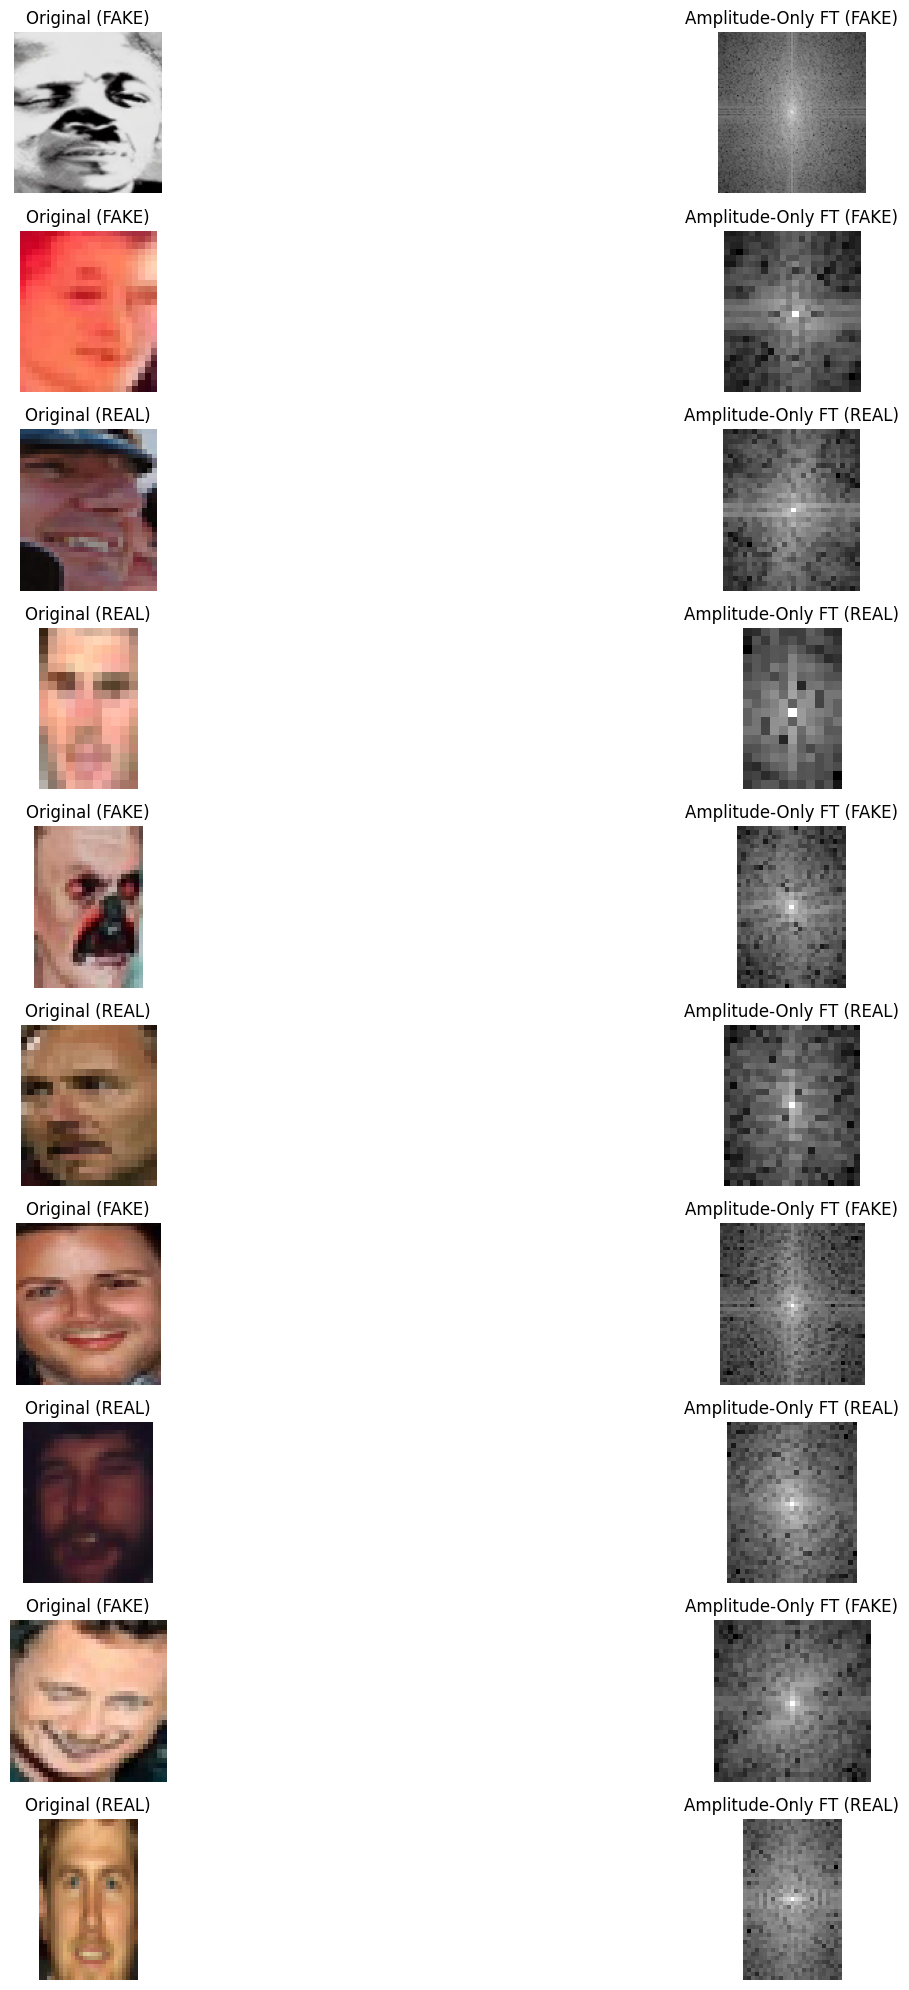

In [17]:

import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 랜덤 10개 선택
indices = random.sample(range(len(train_paths)), 10)

plt.figure(figsize=(20, 20))

for i, idx in enumerate(indices):
    img_path = train_paths[idx]
    label = train_labels[idx]
    label_text = "FAKE" if label == 1 else "REAL"

    # --- 원본 이미지 ---
    orig = Image.open(img_path).convert("RGB")

    # --- FT 변환 (amplitude_only) ---
    ft_img = preprocess_FT(orig, Type=1)   # 1 = amplitude_only

    # --- 출력 ---
    plt.subplot(10, 2, i*2 + 1)
    plt.imshow(orig)
    plt.title(f"Original ({label_text})")
    plt.axis("off")

    plt.subplot(10, 2, i*2 + 2)
    plt.imshow(ft_img)
    plt.title(f"Amplitude-Only FT ({label_text})")
    plt.axis("off")

plt.tight_layout()
plt.show()